In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas
import datetime
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def pred_bin_out(row, nBins, binTimeRes):
    """
    Given the prediction label, get the actual
    output in bins by converting the label into
    binary representation. For ex, label 2 would
    convert to 10 and 5 to 101 and so on.
    """
    # Note we need the binary format to be consistent
    # with the actual labels, i.e., it depends on the 
    # number of bins. For example, 2 could be 10 or 010.
    binFormtStr = '{0:0' + str(nBins) + 'b}'
    predBinStr = binFormtStr.format(row["pred_label"])
    # Now add these into different pred bins
    for _n, _pb in enumerate(predBinStr):
        row["pbin_" + str(_n)] = int(_pb)
    if row["label"] == 0:
        if row["pred_label"] == 0:
            predType = "TN"
        else:
            predType = "FP"
    if row["label"] == 1:
        if row["pred_label"] == 1:
            predType = "TP"
        else:
            predType = "FN"
    row["pred_type"] = predType
    return row

In [3]:
colNames = ["date"]
nBins = 1
binRes = 90
for _nb in range(nBins):
    colNames += [ "bin_" + str(_nb) ]
colNames += ["label", "del_minutes","pred_label"]
for _nb in range(nBins):
    # there are 2 probs for each bin
    # one zero prob and other 1 prob
    colNames += [ "prob_type_0_b_" + str(_nb) ]
    colNames += [ "prob_type_1_b_" + str(_nb) ]
predDF = pandas.read_csv("../data/resnet_test_data_pred.csv", names=colNames,\
                     header=0, parse_dates=["date"])
predDF = predDF.apply( pred_bin_out, args=(nBins,binRes,),\
                      axis=1 )
predDF.head()

,date,bin_0,label,del_minutes,pred_label,prob_type_0_b_0,prob_type_1_b_0,pbin_0,pred_type
0,2015-01-27 22:50:00,1,1,29.0,1,0.316822,0.683178,1,TP
1,2015-01-27 22:55:00,1,1,24.0,1,0.323714,0.676286,1,TP
2,2015-01-27 23:00:00,1,1,19.0,1,0.348204,0.651796,1,TP
3,2015-01-27 23:05:00,1,1,14.0,1,0.350489,0.649511,1,TP
4,2015-01-27 23:10:00,1,1,9.0,1,0.329317,0.670683,1,TP


In [4]:
fpPredDF = predDF[ predDF["pred_type"] == "FP" ]
start_date = predDF["date"].min() - datetime.timedelta(hours=2)
end_date = predDF["date"].max()
print start_date, end_date

2015-01-27 20:50:00 2017-12-31 23:55:00


In [5]:
omn_dbdir = "../data/sqlite3/"
omn_db_name = "omni_sw_imf.sqlite"
omn_table_name = "imf_sw"
timeDelHours = 0.5

In [6]:
# read omni data
conn = sqlite3.connect(omn_dbdir + omn_db_name,
                       detect_types = sqlite3.PARSE_DECLTYPES)
# load data to a dataframe
command = "SELECT datetime, Bz, Vx, By FROM {tb} WHERE datetime BETWEEN '{stm}' and '{etm}'"
command = command.format(tb=omn_table_name,\
                         stm=start_date, etm=end_date)
omnDF = pandas.read_sql(command, conn)
# drop nan's
omnDF.dropna(inplace=True)
# Normalize the data
# omnDF[["Bz", "Vx", "By"]] = omnDF[["Bz", "Vx", "By"]].apply(\
#                                 lambda x: (x - x.mean()) / x.std())
omnDF.head()

,datetime,Bz,Vx,By
4,2015-01-27 21:02:00,-4.18,-471.6,-0.10
5,2015-01-27 21:03:00,-4.00,-471.6,-1.09
6,2015-01-27 21:04:00,-3.67,-472.8,-2.03
7,2015-01-27 21:05:00,-4.78,-478.8,-1.25
8,2015-01-27 21:06:00,-4.64,-478.8,-1.19


In [7]:
omnDF.describe()

,Bz,Vx,By
count,1.128853e+06,1.128853e+06,1.128853e+06
mean,-8.850344e-02,-4.441188e+02,3.998089e-01
std,3.431626e+00,1.020174e+02,4.108233e+00
min,-3.898000e+01,-8.581000e+02,-3.217000e+01
25%,-1.910000e+00,-5.101000e+02,-2.340000e+00
50%,-7.000000e-02,-4.231000e+02,5.600000e-01
75%,1.770000e+00,-3.647000e+02,3.100000e+00
max,3.298000e+01,-2.472000e+02,3.234000e+01


In [8]:
# get the dates from the sel type
# and store the results in a dict!
delTimeList = [ 0.25, 0.5, 1, 2 ]
omnVarDict = {}
for _pt in predDF["pred_type"].unique():
    selDFDates = predDF[ predDF["pred_type"] == _pt ]["date"].tolist()
    # Now we need the time history at each of these dates
    for _dtl in delTimeList:
        allDatesList = []
        for _cd in selDFDates:
            _ed =_cd - datetime.timedelta(minutes=int(_dtl*60))
            _cdtList = [ _ed + datetime.timedelta(minutes=_x) for _x in range(int(_dtl*60)) ]
            allDatesList += _cdtList
        _resDF = omnDF[ omnDF["datetime"].isin(allDatesList) ]
        _currKey = _pt + str( int(_dtl*60) )
        omnVarDict[_currKey] = _resDF

In [9]:
omnVarDict.keys()

['TN120',
 'FN30',
 'TP60',
 'FP60',
 'FN120',
 'TN60',
 'FP30',
 'FN60',
 'TP15',
 'FP120',
 'TP30',
 'TP120',
 'FP15',
 'TN15',
 'TN30',
 'FN15']

In [10]:
omnVarDict["FN30"].describe()

,Bz,Vx,By
count,45506.000000,45506.000000,45506.000000
mean,0.150715,-424.508889,0.059353
std,2.572454,78.234721,4.141110
min,-20.490000,-840.500000,-18.340000
25%,-1.420000,-471.775000,-2.730000
50%,-0.130000,-410.000000,0.110000
75%,1.420000,-365.900000,2.870000
max,20.020000,-270.800000,23.370000


In [11]:
omnVarDict["TP30"].describe()

,Bz,Vx,By
count,197668.000000,197668.000000,197668.000000
mean,-2.207463,-521.430575,1.029971
std,3.722396,104.052823,4.541266
min,-29.180000,-840.500000,-26.820000
25%,-3.850000,-605.400000,-1.860000
50%,-1.980000,-516.700000,1.290000
75%,-0.180000,-438.400000,3.790000
max,29.810000,-265.900000,29.050000


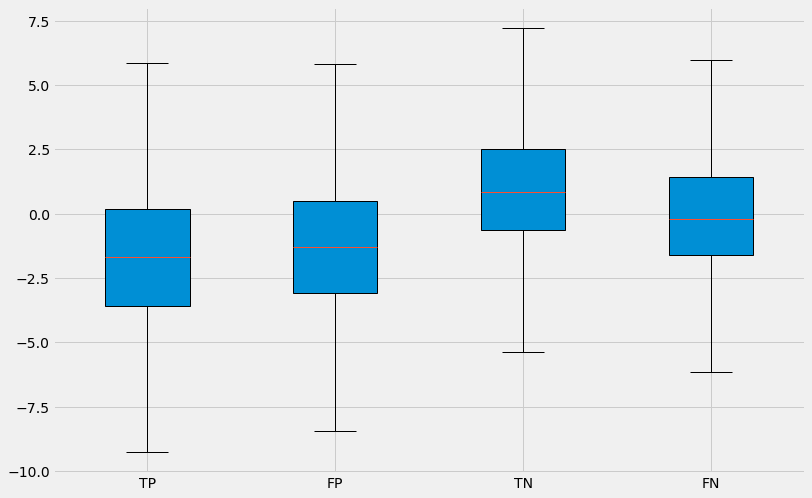

In [12]:
plt.style.use("fivethirtyeight")

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)

coll120Bz = [ omnVarDict["TP60"]["Bz"].values, omnVarDict["FP60"]["Bz"].values,\
        omnVarDict["TN60"]["Bz"].values, omnVarDict["FN60"]["Bz"].values]
ax1.boxplot( coll120Bz, patch_artist=True, showfliers=False )

# ax1.set_ylim( [-5, 5] )

ax1.set_xticklabels(['TP', 'FP', 'TN', 'FN'])

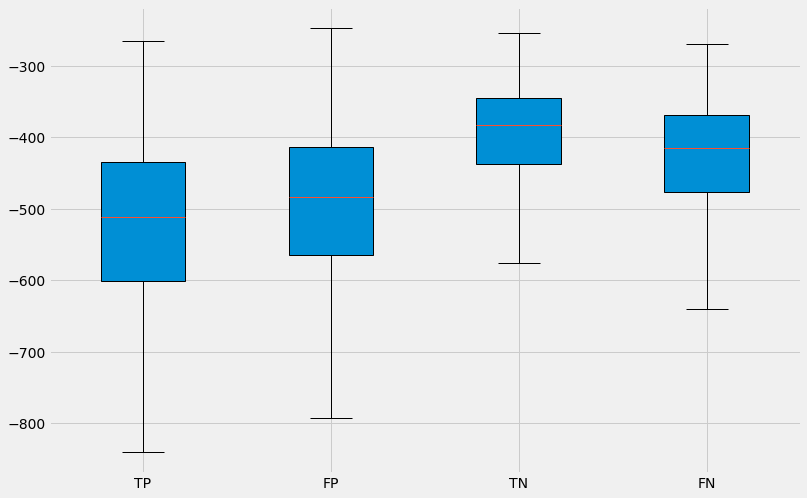

In [13]:
plt.style.use("fivethirtyeight")
f = plt.figure(figsize=(12, 8))
ax2 = f.add_subplot(1,1,1)

coll120Vx = [ omnVarDict["TP60"]["Vx"].values, omnVarDict["FP60"]["Vx"].values,\
        omnVarDict["TN60"]["Vx"].values, omnVarDict["FN60"]["Vx"].values]
ax2.boxplot( coll120Vx, patch_artist=True, showfliers=False )

ax2.set_xticklabels(['TP', 'FP', 'TN', 'FN'])

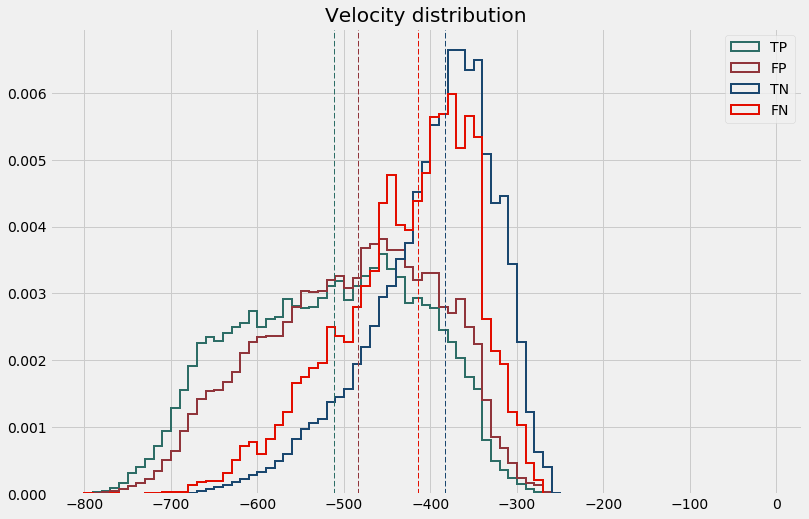

In [14]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
histIntSel = 60
plotParamList = [ "TP" + str(histIntSel), "FP" + str(histIntSel),\
                "TN" + str(histIntSel), "FN" + str(histIntSel)]
bins = range(-800,0,10)
# the histogram of the data
n, bins, patches = ax.hist( omnVarDict[plotParamList[0]]["Vx"].values,\
                           bins=bins, histtype='step',linewidth=2,\
                           color="#2d6d66", label="TP", normed=True )
# plot the median
ax.axvline( x=numpy.median(omnVarDict[plotParamList[0]]["Vx"].values),\
           color='#2d6d66', linestyle='--',linewidth=1 )


n, bins, patches = ax.hist( omnVarDict[plotParamList[1]]["Vx"].values,\
                           bins=bins, histtype='step',linewidth=2,\
                           color="#90353b", label="FP", normed=True )
# plot the median
ax.axvline( x=numpy.median(omnVarDict[plotParamList[1]]["Vx"].values),\
           color='#90353b', linestyle='--',linewidth=1 )

n, bins, patches = ax.hist( omnVarDict[plotParamList[2]]["Vx"].values,\
                           bins=bins, histtype='step',linewidth=2,\
                           color="#1a476f", label="TN", normed=True )
# plot the median
ax.axvline( x=numpy.median(omnVarDict[plotParamList[2]]["Vx"].values),\
           color='#1a476f', linestyle='--',linewidth=1 )

n, bins, patches = ax.hist( omnVarDict[plotParamList[3]]["Vx"].values,\
                           bins=bins, histtype='step',linewidth=2,\
                           color="#e30e00", label="FN", normed=True )
# plot the median
ax.axvline( x=numpy.median(omnVarDict[plotParamList[3]]["Vx"].values),\
           color='#e30e00', linestyle='--',linewidth=1 )

ax.legend()

ax.set_title("Velocity distribution")

f.savefig("../plots/categorical_vx_dist.pdf", bbox_inches='tight')

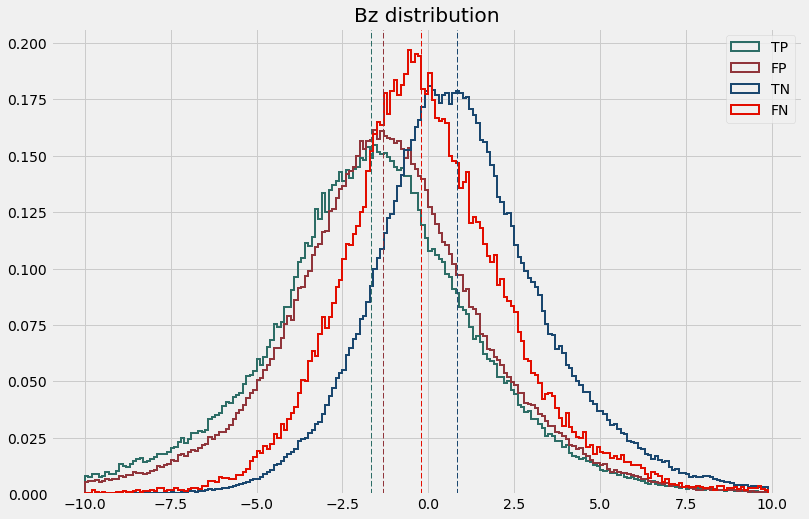

In [15]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

histIntSel = 60
plotParamList = [ "TP" + str(histIntSel), "FP" + str(histIntSel),\
                "TN" + str(histIntSel), "FN" + str(histIntSel)]

bins = numpy.arange(-10,10,0.1)
# the histogram of the data
n, bins, patches = ax.hist( omnVarDict[plotParamList[0]]["Bz"].values,\
                           bins=bins, histtype='step',linewidth=2,\
                           color="#2d6d66", label="TP", normed=True )
# plot the median
ax.axvline( x=numpy.median(omnVarDict[plotParamList[0]]["Bz"].values),\
           color='#2d6d66', linestyle='--',linewidth=1 )

n, bins, patches = ax.hist( omnVarDict[plotParamList[1]]["Bz"].values,\
                           bins=bins, histtype='step',linewidth=2,\
                           color="#90353b", label="FP", normed=True )
# plot the median
ax.axvline( x=numpy.median(omnVarDict[plotParamList[1]]["Bz"].values),\
           color='#90353b', linestyle='--',linewidth=1 )

n, bins, patches = ax.hist( omnVarDict[plotParamList[2]]["Bz"].values,\
                           bins=bins, histtype='step',linewidth=2,\
                           color="#1a476f", label="TN", normed=True )
# plot the median
ax.axvline( x=numpy.median(omnVarDict[plotParamList[2]]["Bz"].values),\
           color='#1a476f', linestyle='--',linewidth=1 )

n, bins, patches = ax.hist( omnVarDict[plotParamList[3]]["Bz"].values,\
                           bins=bins, histtype='step',linewidth=2,\
                           color="#e30e00", label="FN", normed=True )
# plot the median
ax.axvline( x=numpy.median(omnVarDict[plotParamList[3]]["Bz"].values),\
           color='#e30e00', linestyle='--',linewidth=1 )

ax.legend()

ax.set_title("Bz distribution")

f.savefig("../plots/categorical_bz_dist.pdf", bbox_inches='tight')

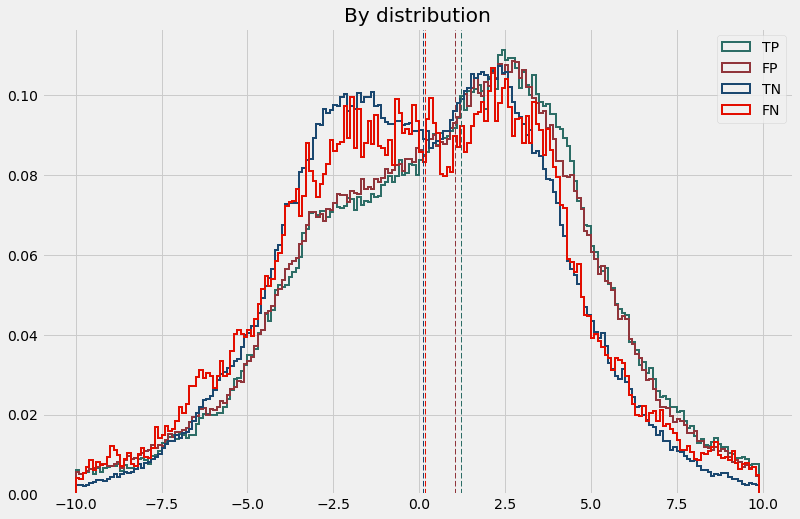

In [16]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

histIntSel = 60
plotParamList = [ "TP" + str(histIntSel), "FP" + str(histIntSel),\
                "TN" + str(histIntSel), "FN" + str(histIntSel)]

bins = numpy.arange(-10,10,0.1)
# the histogram of the data
n, bins, patches = ax.hist( omnVarDict[plotParamList[0]]["By"].values,\
                           bins=bins, histtype='step',linewidth=2,\
                           color="#2d6d66", label="TP", normed=True )
# plot the median
ax.axvline( x=numpy.median(omnVarDict[plotParamList[0]]["By"].values),\
           color='#2d6d66', linestyle='--',linewidth=1 )

n, bins, patches = ax.hist( omnVarDict[plotParamList[1]]["By"].values,\
                           bins=bins, histtype='step',linewidth=2,\
                           color="#90353b", label="FP", normed=True )
# plot the median
ax.axvline( x=numpy.median(omnVarDict[plotParamList[1]]["By"].values),\
           color='#90353b', linestyle='--',linewidth=1 )

n, bins, patches = ax.hist( omnVarDict[plotParamList[2]]["By"].values,\
                           bins=bins, histtype='step',linewidth=2,\
                           color="#1a476f", label="TN", normed=True )
# plot the median
ax.axvline( x=numpy.median(omnVarDict[plotParamList[2]]["By"].values),\
           color='#1a476f', linestyle='--',linewidth=1 )

n, bins, patches = ax.hist( omnVarDict[plotParamList[3]]["By"].values,\
                           bins=bins, histtype='step',linewidth=2,\
                           color="#e30e00", label="FN", normed=True )
# plot the median
ax.axvline( x=numpy.median(omnVarDict[plotParamList[3]]["By"].values),\
           color='#e30e00', linestyle='--',linewidth=1 )

ax.legend()

ax.set_title("By distribution")

f.savefig("../plots/categorical_by_dist.pdf", bbox_inches='tight')

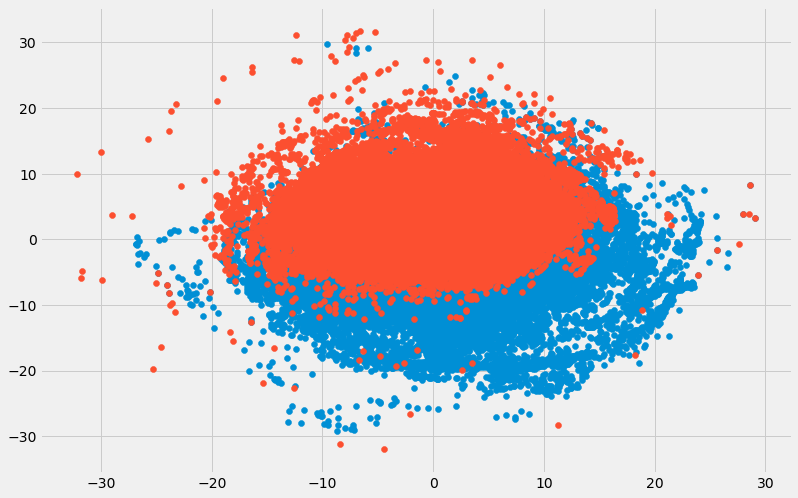

In [21]:
# omnVarDict[plotParamList[0]]["By"]

f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

ax.scatter( omnVarDict["TP30"]["By"].values, omnVarDict["TP30"]["Bz"].values )
ax.scatter( omnVarDict["TN30"]["By"].values, omnVarDict["TN30"]["Bz"].values )